In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley, MonteCarloShapleyBatch
from shapkit.sgd_shapley import SGDshapley
from shapkit.plots import plot_shapley

%load_ext autoreload
%autoreload 2

In [2]:
try:
    from catboost import CatBoostClassifier, Pool
except:
    ! pip install catboost 

# Load dataset

In [3]:
df = pd.read_csv("../dataset/compas/compas.csv")
df.age = df.age.astype("int")
df.priors_count = df.priors_count.astype("int")
df.columns = ['gender', 'ethnicity', 'legal_status', 'custody_status', 'marital_status',
              'recidivism_probability', 'age', 'priors_crimes_count']
df = df[df.recidivism_probability.isin(['Low', 'High'])]
df.head(5)

,gender,ethnicity,legal_status,custody_status,marital_status,recidivism_probability,age,priors_crimes_count
0,Male,Caucasian,Pretrial,Jail Inmate,Married,Low,31,0
1,Male,African-American,Pretrial,Jail Inmate,Single,High,21,1
3,Female,African-American,Pretrial,Jail Inmate,Single,Low,30,0
4,Male,Hispanic,Pretrial,Jail Inmate,Single,High,32,20
5,Female,Caucasian,Pretrial,Jail Inmate,Single,Low,49,0


In [4]:
target_names = 'recidivism_probability'
columns = [col for col in df.columns if col != target_names]
X = df[columns].copy()
labels = df[target_names].copy()
y = np.where(labels == 'Low', 0, 1)
print("Classes: {0}".format(np.unique(labels)))

Classes: ['High' 'Low']


In [5]:
d = X.shape[1]
n = 2**d - 2
d, n

(7, 126)


# Train a ML model

In [6]:
cat_features = ['gender', 'ethnicity', 'legal_status', 'custody_status', 'marital_status']
cat_features_index = [i for i, col in enumerate(X.columns) if col in cat_features]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.33,
                                                  random_state=42)
test_data = catboost_pool = Pool(X_test, y_test,
                                 cat_features=cat_features_index)
val_data = catboost_pool = Pool(X_val, y_val,
                                cat_features=cat_features_index)

model = CatBoostClassifier(iterations=200,
                           depth=5,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=20)
# train the model
model.fit(X_train, y_train,
          cat_features=cat_features_index,
          eval_set=val_data)
# make the prediction using the resulting model
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
print("Test Accuracy: {0:.2}".format(np.mean(preds_class == y_test)))

0:	learn: 0.4642593	test: 0.4567796	best: 0.4567796 (0)	total: 58.3ms	remaining: 11.6s
20:	learn: 0.3708433	test: 0.3890843	best: 0.3890843 (20)	total: 224ms	remaining: 1.91s
40:	learn: 0.3393934	test: 0.3795197	best: 0.3793465 (36)	total: 367ms	remaining: 1.42s
60:	learn: 0.3238395	test: 0.3798016	best: 0.3765597 (54)	total: 496ms	remaining: 1.13s
80:	learn: 0.3088234	test: 0.3846077	best: 0.3765597 (54)	total: 634ms	remaining: 932ms
100:	learn: 0.3002132	test: 0.3852011	best: 0.3765597 (54)	total: 773ms	remaining: 758ms
120:	learn: 0.2900827	test: 0.3868944	best: 0.3765597 (54)	total: 972ms	remaining: 634ms
140:	learn: 0.2783800	test: 0.3916980	best: 0.3765597 (54)	total: 1.11s	remaining: 464ms
160:	learn: 0.2689697	test: 0.3942314	best: 0.3765597 (54)	total: 1.27s	remaining: 308ms
180:	learn: 0.2609107	test: 0.3952044	best: 0.3765597 (54)	total: 1.43s	remaining: 150ms
199:	learn: 0.2514048	test: 0.3948909	best: 0.3765597 (54)	total: 1.54s	remaining: 0us

bestTest = 0.3765596588
best

# Define the game

In [7]:
fc = lambda x: model.predict_proba(x)[1]

### Pick an individual x to explain

In [8]:
x = X_test.iloc[np.random.choice(len(X_test), size=1)[0],:]
x_class = int(model.predict(x.values))
print(x)
print()
print("Prediction for x: {0:.0f}".format(x_class))

gender                             Male
ethnicity              African-American
legal_status                   Pretrial
custody_status              Jail Inmate
marital_status                   Single
age                                  31
priors_crimes_count                   5
Name: 9515, dtype: object

Prediction for x: 1


### Single reference belonging to the opposite class (according to the model)

In [9]:
X_opposite_class = X_train[model.predict(X_train) != x_class].copy()
reference = X_opposite_class.iloc[np.random.choice(len(X_opposite_class), size=1)[0],:]
ref_class = int(model.predict(reference.values))
print(reference)
print()
print("Prediction for this reference: {0:.0f}".format(ref_class))

gender                        Male
ethnicity                   Arabic
legal_status              Pretrial
custody_status         Jail Inmate
marital_status              Single
age                             40
priors_crimes_count              0
Name: 4128, dtype: object

Prediction for this reference: 0


#### Exact Shapley Values

In [10]:
true_shap = ShapleyValues(x=x, fc=fc, ref=reference)

100%|██████████| 7/7 [00:00<00:00, 12.82it/s]


In [11]:
true_shap

gender                 0.000000
ethnicity              0.342291
legal_status           0.000000
custody_status         0.000000
marital_status         0.000000
age                    0.246956
priors_crimes_count    0.228301
dtype: float64

#### Approximation methods

##### Monte Carlo 

In [12]:
mc_shap = MonteCarloShapley(x=x, fc=fc, ref=reference, n_iter=1000)
mc_shap

  2%|▏         | 17/1000 [00:00<00:06, 156.91it/s]

new dimension 3


100%|██████████| 1000/1000 [00:03<00:00, 256.04it/s]


gender                 0.000000
ethnicity              0.338690
legal_status           0.000000
custody_status         0.000000
marital_status         0.000000
age                    0.243700
priors_crimes_count    0.235157
dtype: float64

In [13]:
%%time
fc_batch = lambda X: model.predict_proba(X)[:,1]
mc_shap_batch = MonteCarloShapleyBatch(x=x, fc=fc_batch, ref=reference, n_iter=1000)
mc_shap_batch

CPU times: user 38.8 ms, sys: 3.64 ms, total: 42.5 ms
Wall time: 34.1 ms


gender                 0.000000
ethnicity              0.335397
legal_status           0.000000
custody_status         0.000000
marital_status         0.000000
age                    0.248611
priors_crimes_count    0.233540
dtype: float64

##### SGD

In [14]:
sgd_est = SGDshapley(d, C=y.max())
sgd_shap = sgd_est.sgd(x=x, fc=fc, ref=reference, n_iter=5000, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 5000/5000 [00:05<00:00, 916.94it/s] 


gender                 0.002901
ethnicity              0.335691
legal_status           0.002575
custody_status         0.005924
marital_status        -0.001207
age                    0.258498
priors_crimes_count    0.213167
dtype: float64

#### Plot 

/home/sgrah/Documents/shapkit/tutorials/shapkit/plots.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.get_axes()[0].set_xticklabels(xticks_label)


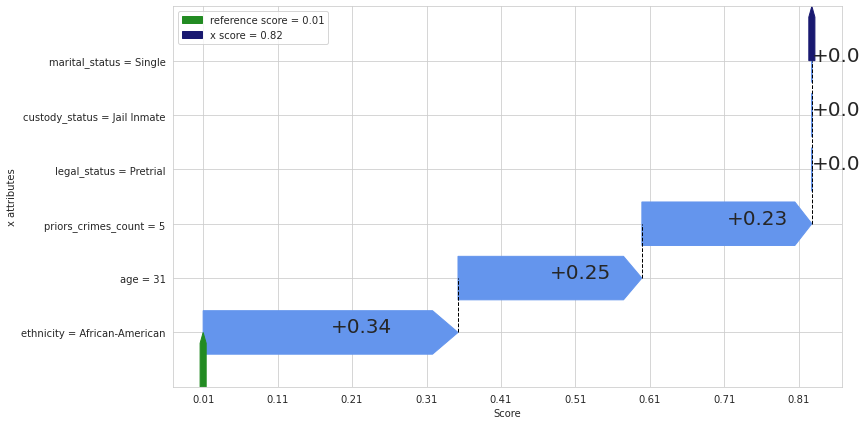

In [15]:
fig =  plot_shapley(x=x, fc=fc, ref=reference, shapley_values=true_shap, n_attributes=6)

### Several references 

In [16]:
n_ref = 100
idx_ref = np.random.choice(X_opposite_class.shape[0], size=n_ref, replace=False).flatten()
references = X_opposite_class.iloc[idx_ref]
references.head(5)

,gender,ethnicity,legal_status,custody_status,marital_status,age,priors_crimes_count
12725,Female,Hispanic,Pretrial,Jail Inmate,Separated,41,0
9509,Male,Caucasian,Pretrial,Jail Inmate,Single,22,0
16013,Male,Caucasian,Pretrial,Jail Inmate,Single,36,1
932,Male,African-American,Pretrial,Jail Inmate,Single,30,2
2607,Male,African-American,Pretrial,Jail Inmate,Single,27,1


#### Approximation methods

##### Monte Carlo 

In [17]:
mc_shaps = MonteCarloShapley(x=x, fc=fc, ref=references, n_iter=1000)
mc_shaps

100%|██████████| 1000/1000 [00:07<00:00, 131.44it/s]


gender                 0.016003
ethnicity              0.136876
legal_status           0.003531
custody_status         0.007997
marital_status         0.042349
age                    0.156839
priors_crimes_count    0.290877
dtype: float64

In [18]:
%%time
mc_shaps_batch = MonteCarloShapleyBatch(x=x, fc=fc_batch, ref=references, n_iter=1000)
mc_shaps_batch

CPU times: user 154 ms, sys: 17.7 ms, total: 172 ms
Wall time: 147 ms


gender                 0.017528
ethnicity              0.150250
legal_status           0.002486
custody_status         0.005117
marital_status         0.042563
age                    0.141010
priors_crimes_count    0.298045
dtype: float64

#### Plots

/home/sgrah/Documents/shapkit/tutorials/shapkit/plots.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.get_axes()[0].set_xticklabels(xticks_label)


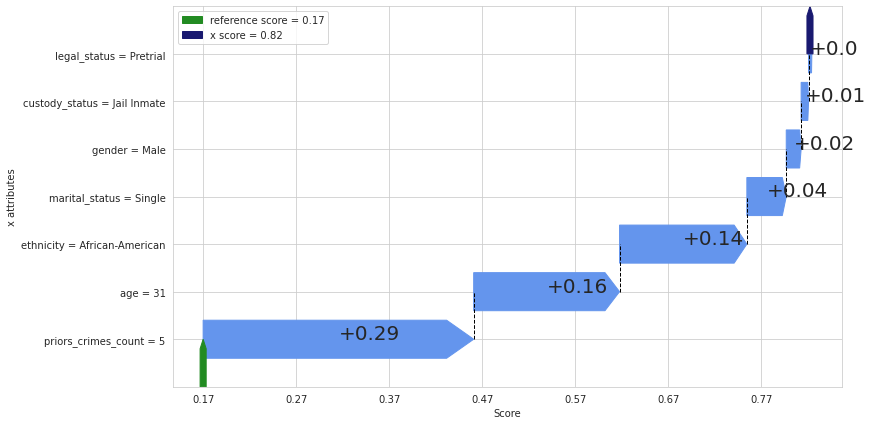

In [19]:
plot_shapley(x=x, fc=fc, ref=references, shapley_values=mc_shaps, n_attributes=20)